<a href="https://colab.research.google.com/github/benkrikler/wavefilter/blob/main/notebooks/train_simple_pulse_finder_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "git+https://github.com/benkrikler/wavefilter#egg=wavefilter"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/benkrikler/wavefilter to /tmp/pip-install-763xv51r/wavefilter_6b2f39c72df842ba8ec9d7ed3db623f3
  Running command git clone -q https://github.com/benkrikler/wavefilter /tmp/pip-install-763xv51r/wavefilter_6b2f39c72df842ba8ec9d7ed3db623f3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
import wavefilter.datasets as wds
import wavefilter.pulse_functions as wps
import wavefilter.models as models
from wavefilter.evaluate import split_parameters, train_parallel_pulse_finder, CaptureActivations
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Make some data

In [3]:
n_samples = 5000 if device == "cpu" else 10000
data, truth = wds.generate_double_pulse_dataset(n_samples, in_noise=0.05, out_noise=2, shape=40, dt2_low=150, dt2_high=700)
# Add an extra dimension for the channel number
data = data[:, np.newaxis, :]
data = torch.tensor(data)
data

tensor([[[-4.1311, -0.3780,  1.0515,  ..., -0.1651, -0.7618, -2.4013]],

        [[ 2.2206, -0.0552, -1.6698,  ..., -3.5371,  2.8608,  0.4608]],

        [[ 2.5861,  3.4435,  2.5418,  ..., 16.2384, 17.0080, 16.9112]],

        ...,

        [[-0.9480,  1.3557,  0.2729,  ...,  1.8502,  5.4185,  1.9376]],

        [[ 0.5505,  1.1702, -1.6627,  ...,  1.9704,  1.6425,  3.7683]],

        [[-0.6443,  4.2464,  1.1331,  ...,  8.6517,  9.4548,  8.3970]]])

In [4]:
ds = torch.utils.data.TensorDataset(data)
train_loader = torch.utils.data.DataLoader(ds,batch_size=100,shuffle=False)
for i, d in enumerate(train_loader):
  print(f"i={i}")
  print([(dd.shape, dd.mean) for dd in d])
  if i > 2: 
    break

i=0
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f1aadac96b0>)]
i=1
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f1a9cb87cb0>)]
i=2
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f1a202fa5f0>)]
i=3
[(torch.Size([100, 1, 998]), <built-in method mean of Tensor object at 0x7f1a202fb5f0>)]


## Set up the model

In [5]:
attention = models.ParallelWeightedModules()
attention.add("conv_pulse_finder", models.Conv1dPulseFinderAttention(100, False), 0)
attention.add("soft_max", models.GlobalSoftMaxAttention(), 1)

model = models.WaveFilter(200, attention).to(device)
#model = models.WaveFilter(200, models.GlobalSoftMaxAttention()).to(device)
print(model)

WaveFilter(
  (convolve): Conv1d(1, 1, kernel_size=(200,), stride=(1,), padding=same)
  (attend): ParallelWeightedModules(
    module_weights=(conv_pulse_finder=0,soft_max=1)
    (conv_pulse_finder): Conv1dPulseFinderAttention(
      (pulse_finder): Conv1d(1, 1, kernel_size=(100,), stride=(1,), padding=same)
      (combine): Conv1d(2, 1, kernel_size=(5,), stride=(1,), padding=same)
      (scale): Conv1d(1, 1, kernel_size=(1,), stride=(1,), padding=same)
    )
    (soft_max): GlobalSoftMaxAttention()
  )
  (encode): Product()
  (reconstruct): TiedFlippedConvolve1D(
    (tied_to): Conv1d(1, 1, kernel_size=(200,), stride=(1,), padding=same)
  )
)


In [6]:
params = split_parameters(model, ['attend'])

In [7]:
lr_schedules = [lambda x: 0.95**x, lambda x: 0.99]
tester = train_parallel_pulse_finder(train_loader, model, param_groups=params, lr_schedules=lr_schedules, device=device, epochs=300)

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:304: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:882.)
  self.padding, self.dilation, self.groups)


## Inspect what we've learnt

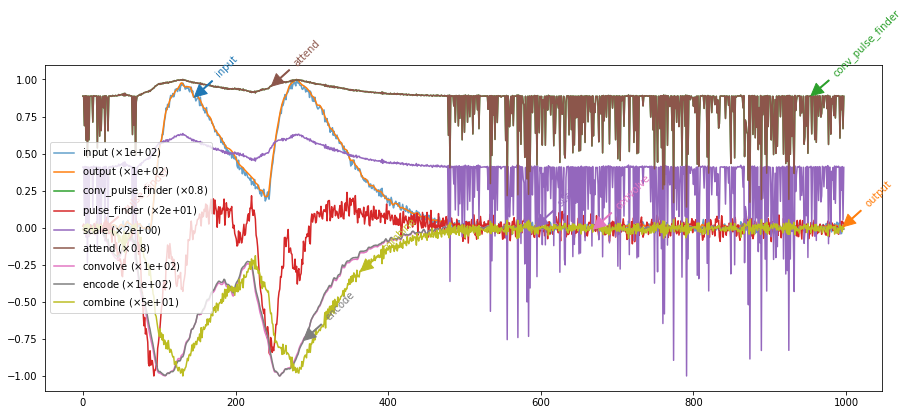

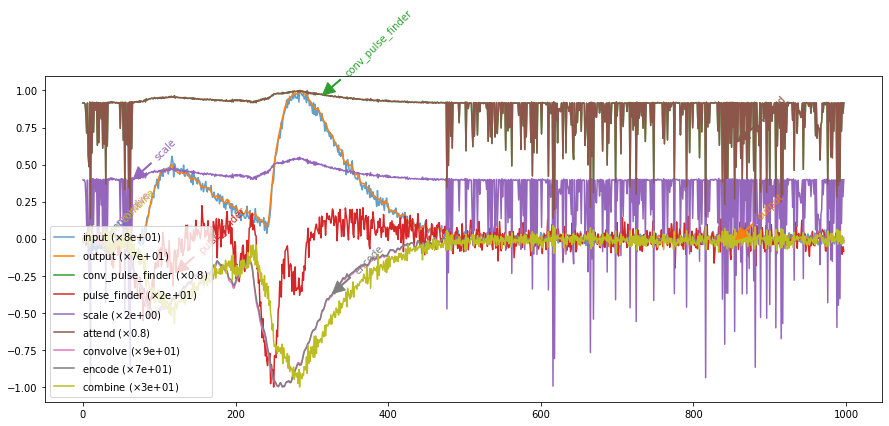

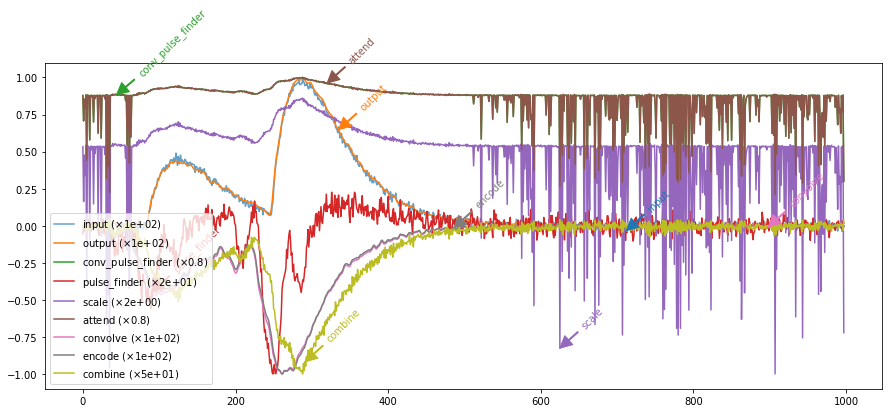

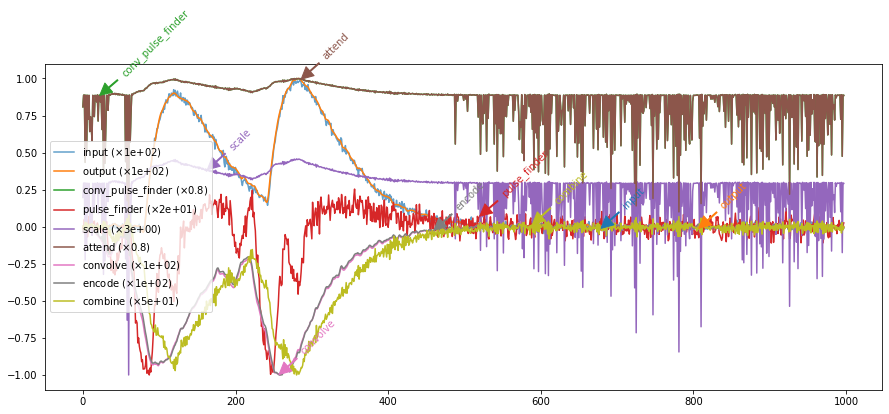

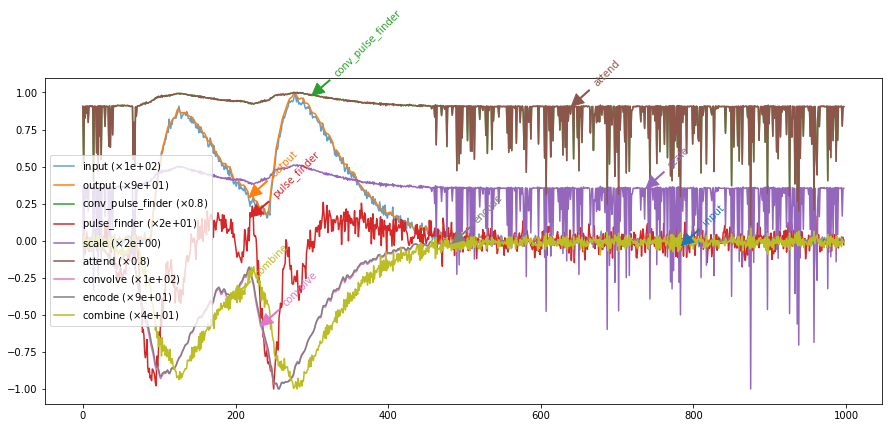

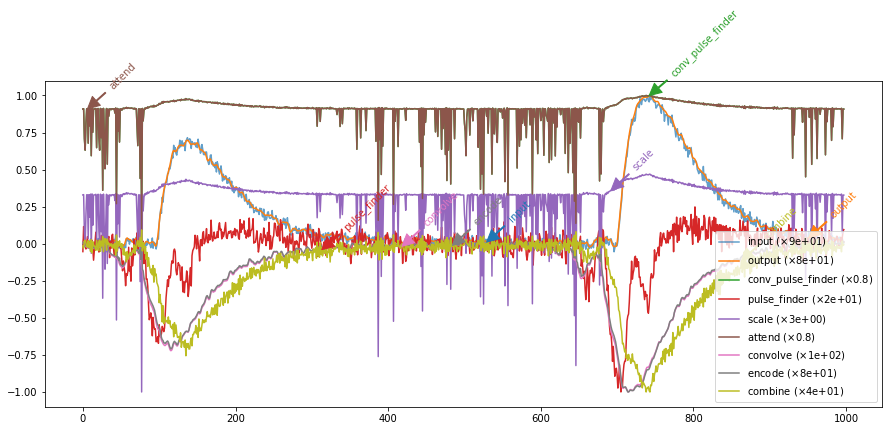

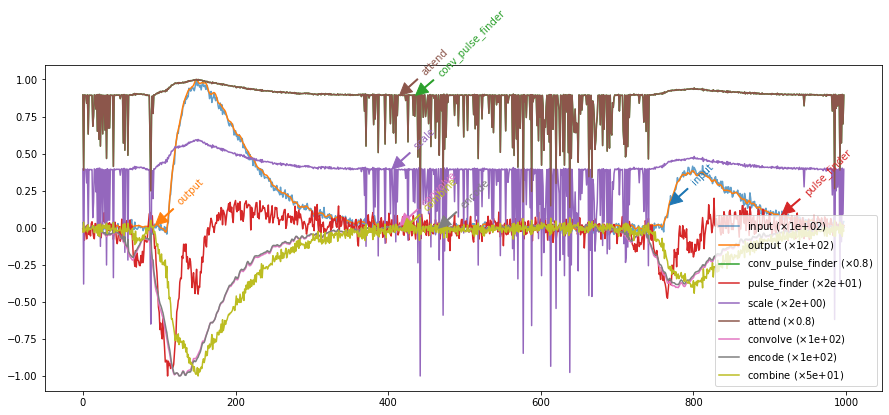

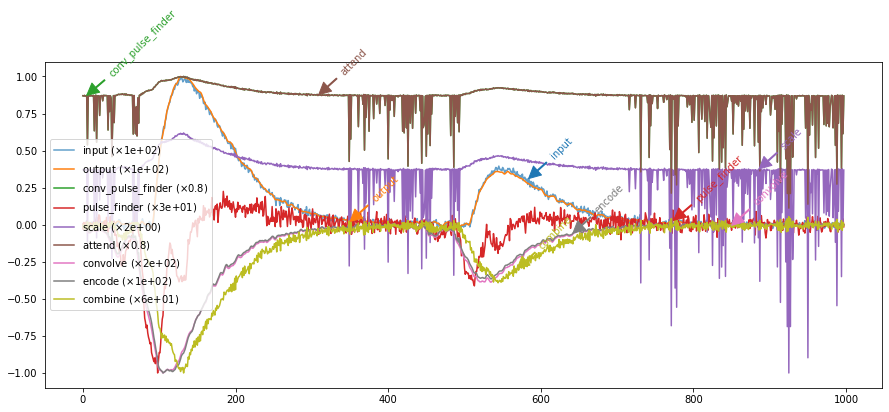

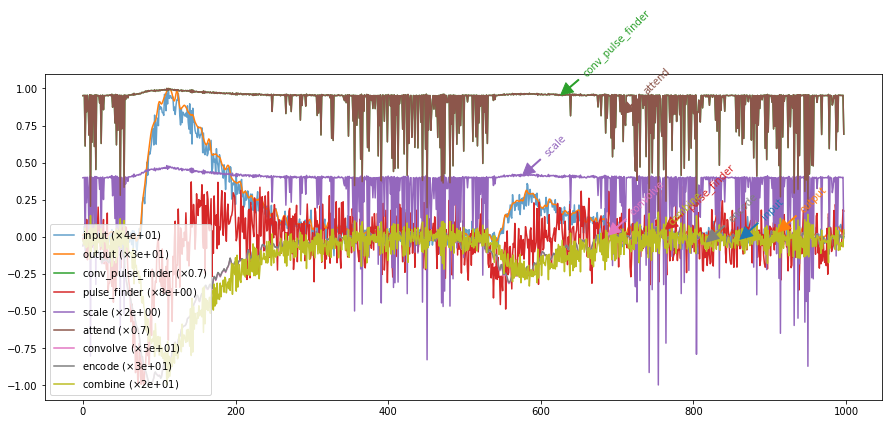

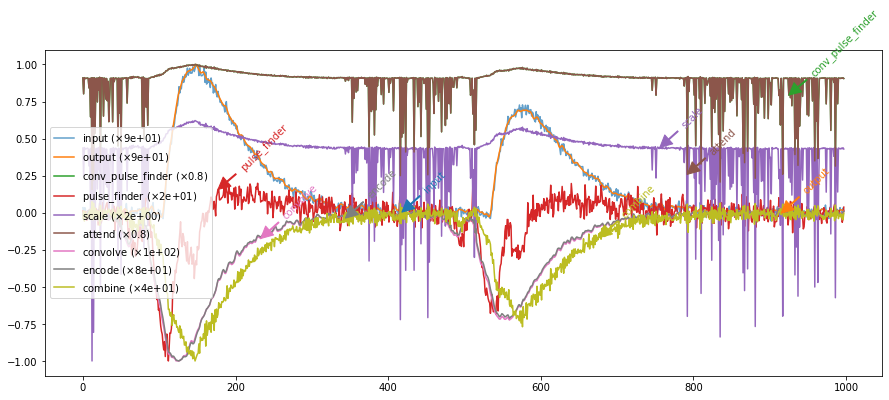

In [8]:
activations = CaptureActivations()
activations.register(model, "attend", "encode", "convolve", "reconstruct")
activations.register(model.attend, "conv_pulse_finder", "soft_max")
activations.register(model.attend.conv_pulse_finder, "pulse_finder", "combine", "scale")

def plot_line(data, label, **kwargs):
  scale = max(data.max(), -data.min())
  lines = plt.plot(data / scale, label=f"{label} ($\\times${scale:.01})", **kwargs)
  x = np.random.randint(len(data))
  y = data[x] / scale
  color = lines[0].get_color()
  plt.annotate(label, (x,y), xycoords="data", textcoords="offset points", xytext=(20,20), arrowprops=dict(width=1, color=color), color=color , rotation=45)
  

def plot_prediction(model, input):
  output = model(input.to(device))
  plot_line(input[0], label="input", alpha=0.7)
  plot_line(output[0].detach().cpu().numpy(), label="output")
  for i in ['conv_pulse_finder', 'pulse_finder', 'scale', 'attend', 'convolve' , 'encode', 'combine']:
  #for i in ['convolve', 'pulse_finder', 'combine', 'scale', 'conv_pulse_finder', 'soft_max', 'attend', 'encode', 'reconstruct']:
    plot_line(activations[i][0].cpu(), label=i)
  plt.legend()
  #plt.yscale("log")

close_time = np.random.choice(np.where(truth[1][:, 1] < 250)[0], 5)
far_time = np.random.choice(np.where(truth[1][:, 1] > 500)[0], 5)
choices = np.concatenate((close_time, far_time))
for i in choices: #np.random.randint(len(data), size=10):
  plt.figure(figsize=(15,6))
  plot_prediction(model, ds[i][0])

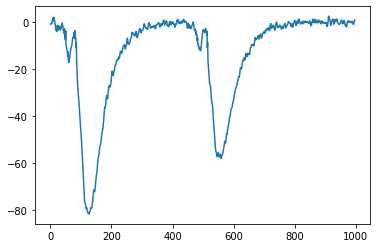

In [9]:
plt.plot(activations["encode"][0].cpu().numpy())
#plt.yscale("log")


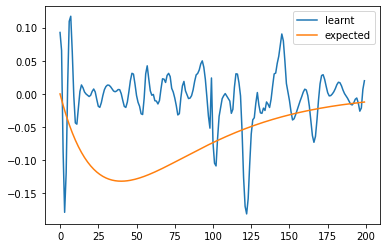

In [10]:
learnt = model.get_parameter("convolve.weight").detach().cpu().numpy()[0,0]
plt.plot(learnt, label="learnt")
expected = wps.simple(np.arange(200), 40)
expected = expected / expected[100]* learnt[100]
plt.plot(expected, label="expected")
plt.legend()

-0.044407047

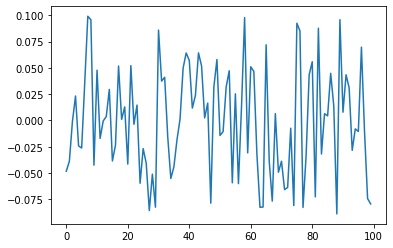

In [11]:
learnt = model.get_parameter("attend.conv_pulse_finder.pulse_finder.weight").detach().cpu().numpy()[0,0]
plt.plot(learnt)
learnt.sum()

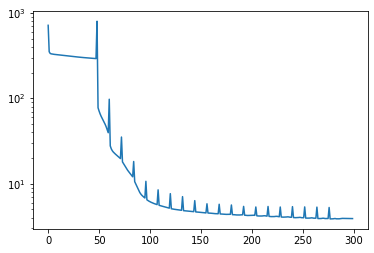

In [12]:
plt.plot(tester.train_loss);
plt.yscale("log")

In [13]:
for name, param in model.named_parameters():
  print(f"{name} = {param}")
  print()

convolve.weight = Parameter containing:
tensor([[[ 9.2714e-02,  6.5608e-02, -8.6510e-02, -1.7871e-01, -1.1924e-01,
           1.5152e-02,  1.0952e-01,  1.1719e-01,  6.2957e-02, -3.4741e-03,
          -4.3802e-02, -4.5688e-02, -2.1639e-02,  3.6498e-03,  1.3521e-02,
           9.2841e-03,  2.9064e-03, -1.2283e-04, -2.1121e-03, -3.9360e-03,
          -2.1131e-03,  3.7558e-03,  7.4140e-03,  2.9607e-03, -8.2619e-03,
          -1.8624e-02, -2.0301e-02, -1.3216e-02, -2.3509e-03,  6.3966e-03,
           1.1142e-02,  1.3307e-02,  1.3162e-02,  1.0986e-02,  7.5637e-03,
           4.3490e-03,  3.2611e-03,  4.3397e-03,  6.6131e-03,  6.3475e-03,
           3.9951e-04, -9.7086e-03, -1.8806e-02, -2.0422e-02, -1.2295e-02,
           3.1165e-03,  2.0071e-02,  3.1108e-02,  2.9899e-02,  1.4875e-02,
          -2.3178e-03, -1.2698e-02, -1.8689e-02, -3.0001e-02, -3.1106e-02,
          -6.3898e-03,  3.0241e-02,  4.2379e-02,  2.2790e-02,  4.7141e-03,
          -2.0126e-03, -7.9182e-04, -1.0265e-02, -1.0807e-02